In [1]:
import os
import random
import cv2
import pandas as pd
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

from tqdm import tqdm

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchsummary import summary

In [2]:
def normalisation(X):
    minX = np.min(X)
    maxX = np.max(X)

    return (X - minX)/(maxX - minX)

In [3]:
def add_noise(img, noise_type="gaussian", mean=0, var=1):
    row, col = 64, 64
    img = img.astype(np.float32)
    sigma = var ** .5

    if noise_type == "gaussian":
        noise = np.random.normal(mean, sigma, img.shape)
        noise = noise.reshape(row, col)
        img = img + noise
        return img

    if noise_type == "speckle":
        noise = np.random.gamma(mean, scale=sigma, size=img.shape)
        img = img * noise
        return img

# Préparation du dataset de Sinogrammes

In [4]:
data = []
imgs_path = "data"

kernel = np.ones((2,2),np.uint8)

for filename in os.listdir(imgs_path):
            f = os.path.join(imgs_path, filename)
            data.append(cv2.threshold(cv2.dilate(cv2.imread(f, 0), kernel), 20, 255, cv2.THRESH_BINARY)[1])

random.shuffle(data)

xtrain = data[:14000]
xtest = data[14000:]

noises = ["gaussian", "speckle"]
mean = 0
var = 10000.
lb = 1.1
a = lb
scale = 1 / (lb - 1)
noise_ct = 0
noise_id = 0
traindata = np.zeros((14000, 64, 64))

for idx in tqdm(range(len(xtrain))):
    traindata[idx] = add_noise(xtrain[idx], noise_type=noises[noise_id], mean=mean, var=var)


print("\n{} noise addition completed to images".format(noises[noise_id]))

testdata = np.zeros((1000, 64, 64))

for idx in tqdm(range(len(xtest))):
    x = add_noise(xtest[idx], noise_type=noises[noise_id], mean=mean, var=var)
    testdata[idx] = x

print("\n{} noise addition completed to images".format(noises[noise_id]))

100%|██████████| 14000/14000 [00:02<00:00, 4953.57it/s]



gaussian noise addition completed to images


100%|██████████| 1000/1000 [00:00<00:00, 4813.67it/s]


gaussian noise addition completed to images


In [5]:
class SinogrameDataset(Dataset):
    def __init__(self, datasetnoised, datasetclean, transform):
        self.noise = datasetnoised
        self.clean = datasetclean
        self.transform = transform

    def __len__(self):
        return len(self.noise)

    def __getitem__(self, idx):
        xNoise = self.noise[idx]
        xClean = self.clean[idx]

        if self.transform is not None:
            xNoise = self.transform(xNoise)
            xClean = self.transform(xClean)

        return xNoise, xClean

In [6]:
tsfms = transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32))])

trainset = SinogrameDataset(traindata, xtrain, tsfms)
testset = SinogrameDataset(testdata, xtest, tsfms)

batch_size = 32

trainloaderSinogram = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloaderSinogram = DataLoader(testset, batch_size=1, shuffle=True)

# Autoencodeur pour le débruitage de Sinogrammes

In [7]:
from torch import nn

class AESinogram(nn.Module):
    def __init__(self):
        super(AESinogram, self).__init__()
        self.encoderDense = nn.Sequential(
            nn.Linear(32 * 32, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True)
        )

        self.decoderDense = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 32 * 32),
            nn.Sigmoid(),
        )

        self.encoderConv1D = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(True),
        )


        self.decoderConv1D = nn.Sequential(
            nn.ConvTranspose1d(in_channels=16, out_channels=32, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose1d(in_channels=32, out_channels=64, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose1d(in_channels=64, out_channels=128, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose1d(in_channels=128, out_channels=1, padding=1, kernel_size=3),
            nn.Sigmoid(),
        )

        self.encoderConv2D = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(True),
        )


        self.decoderConv2D = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=128, out_channels=1, padding=1, kernel_size=3),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoderConv1D(x)
        x = self.decoderConv1D(x)

        return x

# Préparation du dataset de Signaux 1D

In [8]:
clean = pd.read_csv('label1f.csv').to_numpy()
noisy = pd.read_csv('train1f.csv').to_numpy()

test_clean = clean[:100]
test_noisy = noisy[:100]

In [9]:
class SignauxDataset(Dataset):
    def __init__(self, clean_data, noisy_data):
        self.clean = clean_data
        self.noisy = noisy_data

    def __len__(self):
        return len(self.clean)

    def __getitem__(self, index):
        clean = normalisation(self.clean[index, :])
        dirty = normalisation(self.noisy[index, :])

        clean_tensor = torch.from_numpy(clean)
        noisy_tensor = torch.from_numpy(dirty)

        clean_tensor = clean_tensor.view(1, -1).type(torch.FloatTensor)
        noisy_tensor = noisy_tensor.view(1, -1).type(torch.FloatTensor)

        return clean_tensor, noisy_tensor

In [10]:
class config:
    batch_size=10
    learning_rate=1e-3
    epochs=50

training_dataset = SignauxDataset(clean[:900], noisy[:900])
test_dataset = SignauxDataset(clean[900:], noisy[900:])

trainloaderSignaux = DataLoader(training_dataset, batch_size=config.batch_size)
testloaderSignaux = DataLoader(test_dataset, batch_size=1)

# Autoencodeur pour le débruitage de Signaux

In [11]:
class AESignaux(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(True),
        )


        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=16, out_channels=32, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose1d(in_channels=32, out_channels=64, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose1d(in_channels=64, out_channels=128, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose1d(in_channels=128, out_channels=1, padding=1, kernel_size=3),
            nn.Sigmoid(),
        )

        self.encoder2 = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),

        )

        self.decoder2 = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 4096),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

# Chargement de réseaux entrainés

In [12]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

signauxAE = AESignaux()
signauxAE = signauxAE.to(device)

sinogramAE = AESinogram()
sinogramAE = sinogramAE.to(device)


signauxAE.load_state_dict(torch.load('presentation/model1f.pth', map_location=torch.device('cpu')))

sinogramAE.load_state_dict(torch.load('presentation/sinogrammeConv1D_10000.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

# Sinogrammes
## Résultat de l'encodeur

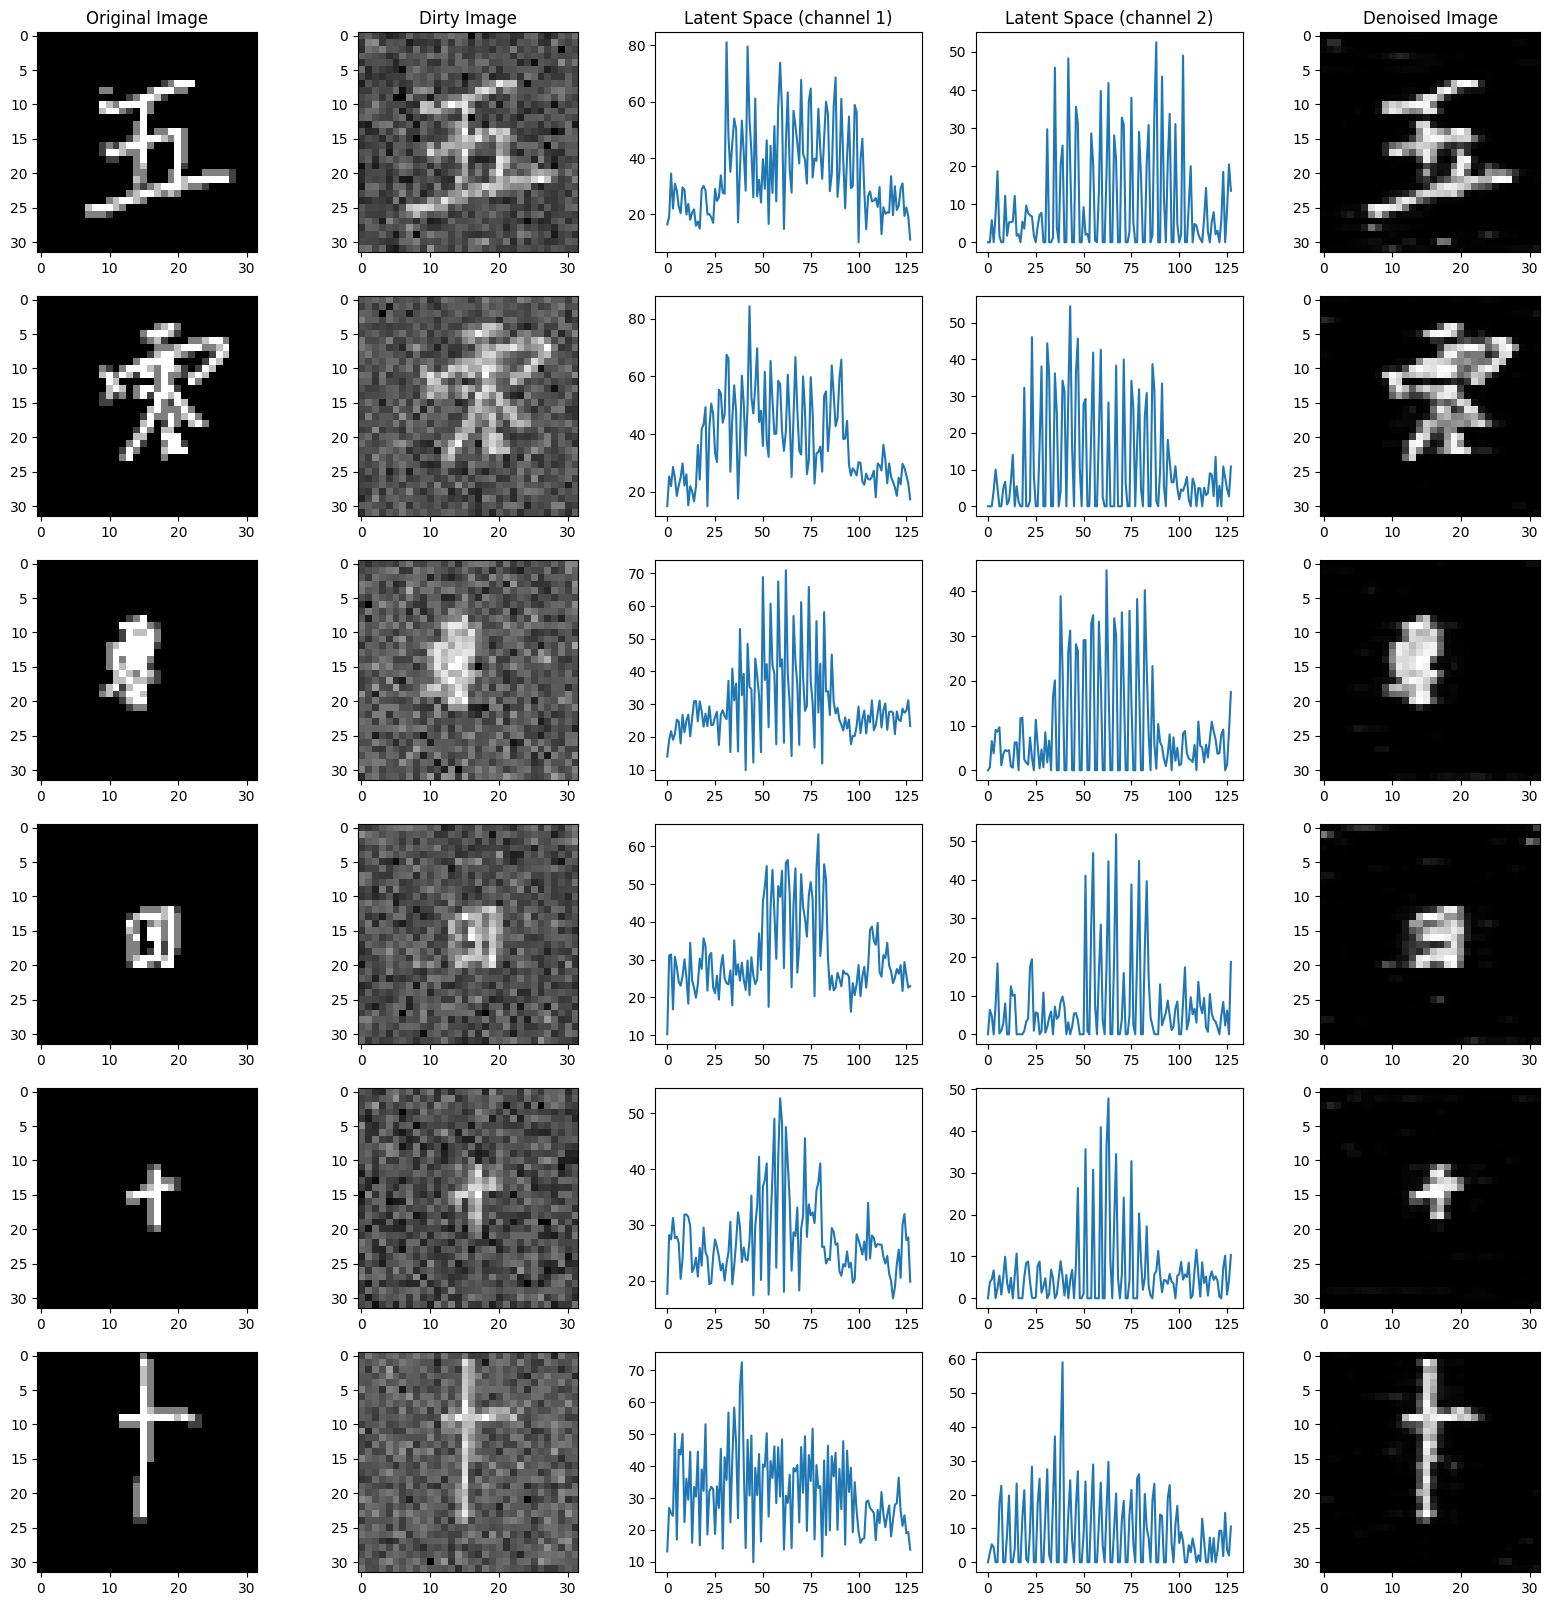

In [15]:
f, axes = plt.subplots(6, 5, figsize=(20, 20))
axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("Dirty Image")
axes[0, 2].set_title("Latent Space (channel 1)")
axes[0, 3].set_title("Latent Space (channel 2)")
axes[0, 4].set_title("Denoised Image")

test_imgs = np.random.randint(0, 500, size=6)
i = 0
for dirty, clean in testloaderSinogram:
    i+=1
    dirty = dirty.view(dirty.size(0), 1, 32*32).type(torch.FloatTensor)
    dirty = dirty.to(device)

    # Encodage
    output_encoder = sinogramAE.encoderConv1D(dirty)

    # Décodage
    output_decoder = sinogramAE.decoderConv1D(output_encoder)


    dirty = dirty.detach().cpu().numpy()
    dirty = dirty.reshape(32,32)

    output_decoder = output_decoder.detach().cpu().numpy()
    output_decoder = output_decoder.reshape(32,32)

    clean = clean.detach().cpu().numpy()
    clean = clean.reshape(32,32)

    latent = output_encoder.detach().cpu().numpy()
    latent = latent.reshape(-1,)


    axes[i-1, 0].imshow(clean, cmap="gray")
    axes[i-1, 1].imshow(dirty, cmap="gray")
    axes[i-1, 2].plot(latent[:128])
    axes[i-1, 3].plot(latent[128:128*2])
    axes[i-1, 4].imshow(output_decoder, cmap="gray")

    if i == 6:
        break

plt.show()

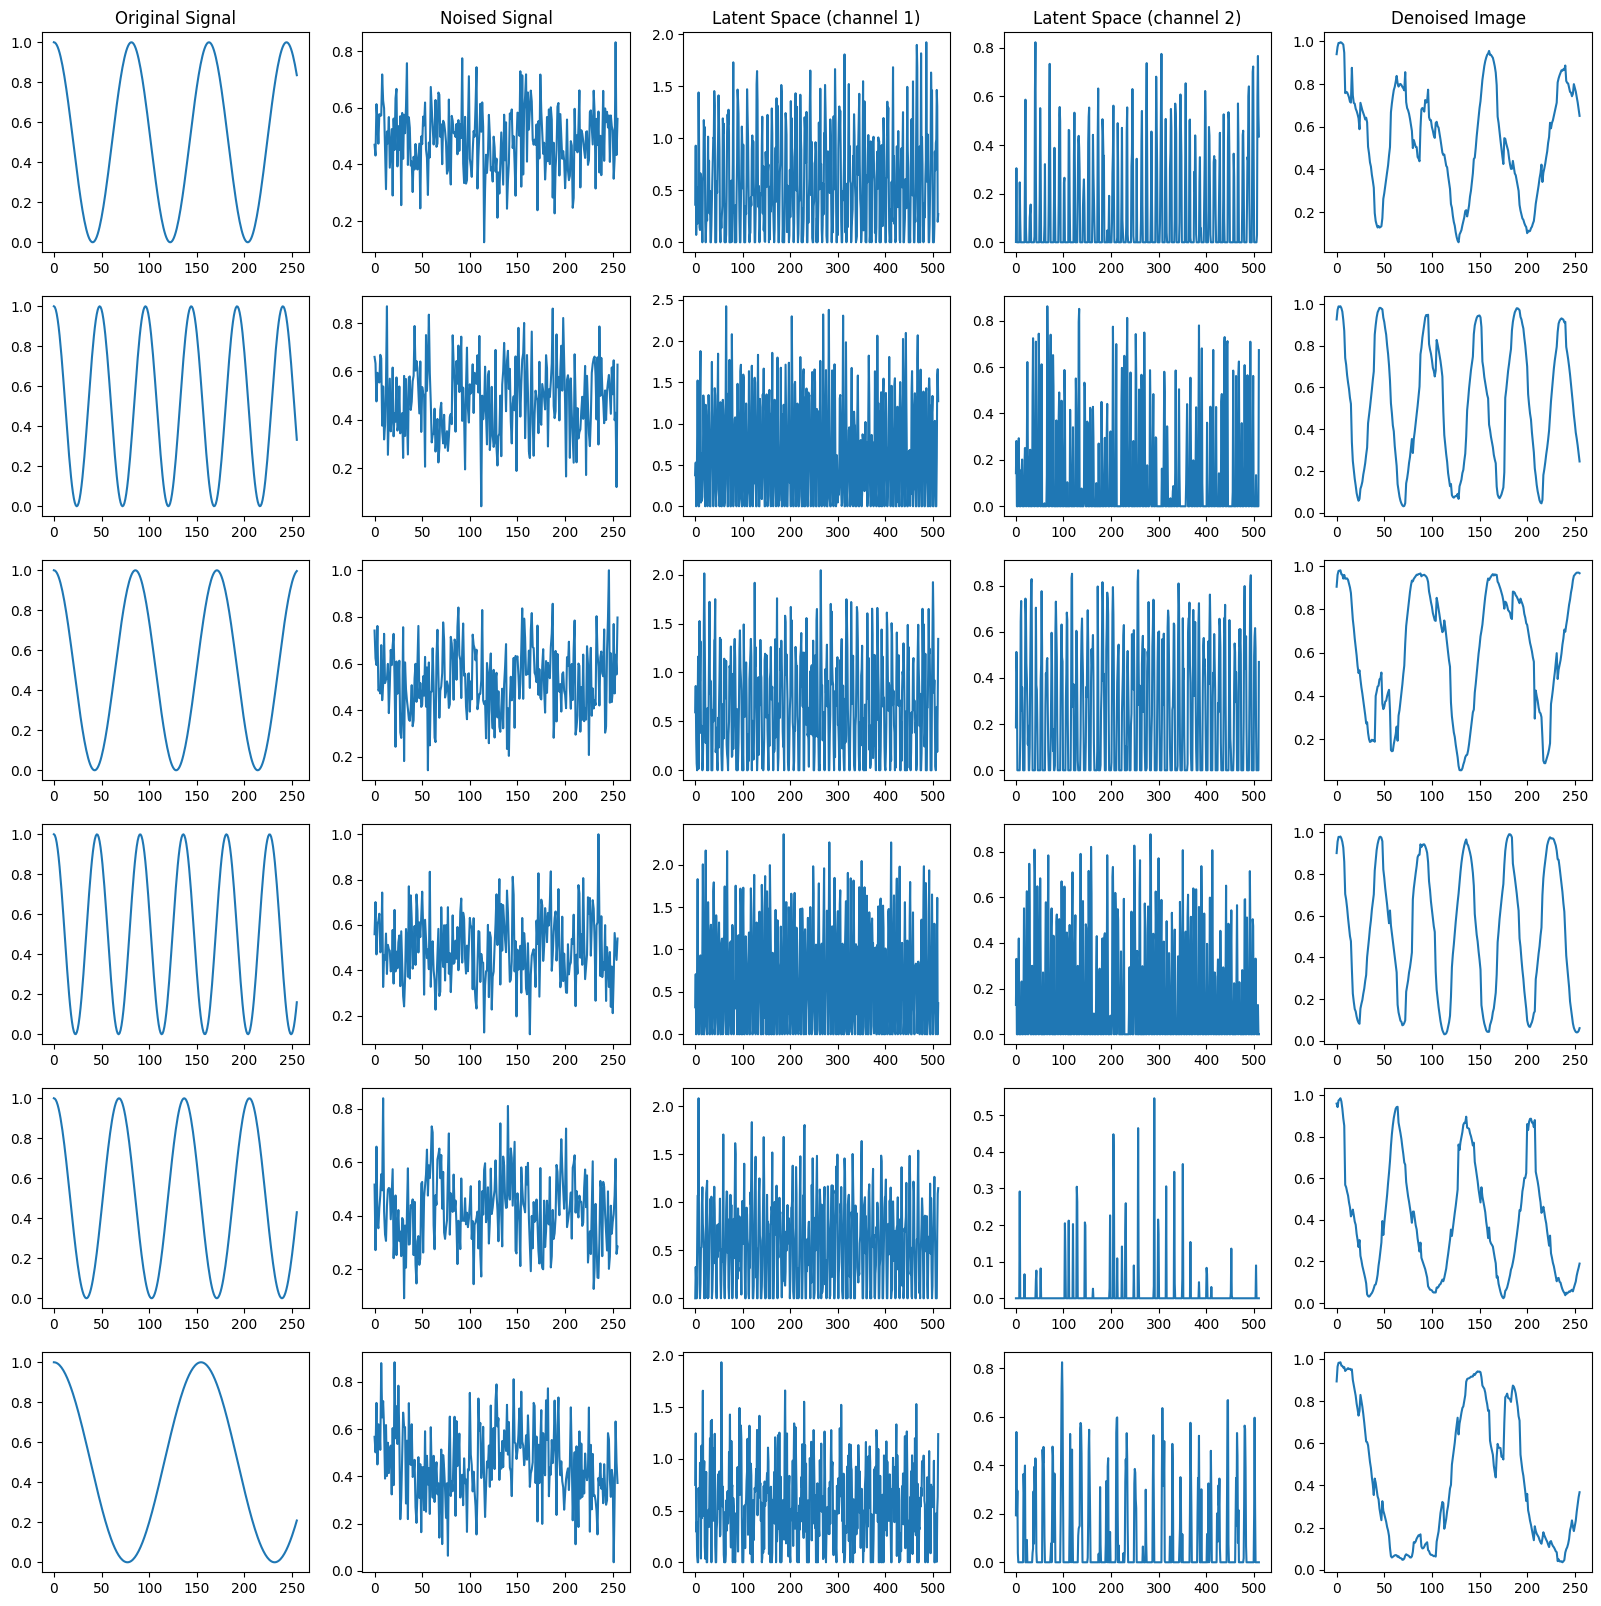

In [14]:
f, axes = plt.subplots(6, 5, figsize=(20, 20))
axes[0, 0].set_title("Original Signal")
axes[0, 1].set_title("Noised Signal")
axes[0, 2].set_title("Latent Space (channel 1)")
axes[0, 3].set_title("Latent Space (channel 2)")
axes[0, 4].set_title("Denoised Image")

test_imgs = np.random.randint(0, 500, size=6)
i = 0
for clean, dirty in testloaderSignaux:
    i+=1
    dirty = dirty.view(dirty.size(0), 1, 4096).type(torch.FloatTensor)
    dirty = dirty.to(device)

    # Encodage
    output_encoder = signauxAE.encoder(dirty)

    # Décodage
    output_decoder = signauxAE.decoder(output_encoder)

    dirty = dirty.detach().cpu().numpy()
    dirty = dirty.reshape(-1,)

    output_decoder = output_decoder.detach().cpu().numpy()
    output_decoder = output_decoder.reshape(-1,)

    clean = clean.detach().cpu().numpy()
    clean = clean.reshape(-1,)

    latent = output_encoder.detach().cpu().numpy()
    latent = latent.reshape(-1,)


    axes[i-1, 0].plot(clean[:256])
    axes[i-1, 1].plot(dirty[:256])
    axes[i-1, 2].plot(latent[:512])
    axes[i-1, 3].plot(latent[512:1024])
    axes[i-1, 4].plot(output_decoder[:256])

    if i == 6:
        break

plt.show()